<center>
<img src="https://habrastorage.org/webt/ia/m9/zk/iam9zkyzqebnf_okxipihkgjwnw.jpeg" />
    
## [mlcourse.ai](https://mlcourse.ai) - Open Machine Learning Course

Автор: [Yury Kashnitsky](https://yorko.github.io). Все материалы распространяются под [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/).

# Задание #8

## Реализация Стохастического Градиентного Спуска (SGD) для регрессии и классификации

Здесь мы реализуем два алгоритма - регрессор и классификатор - на основе стохастического градиентного спуска (SGD).


**Задача состоит в том, чтобы:**
 1. написать код и выполнить вычисления в ячейках ниже;
 2. выбрать ответы в [веб-форме](https://forms.gle/gC4PN9ntDru4sbZU7).

*Если вы уверены, что в задании/решении что-то не на 100% верно, пожалуйста, оставьте свой отзыв через указанную веб-форму ↑*

-----


## 1. Линейная Регрессия и Стохастический Градиентный Спуск (SGD)

В [этой статье](https://mlcourse.ai/book/topic08/topic08_sgd_hashing_vowpal_wabbit.html) мы описали, как обучить online-регрессор, минимизируя при этом функцию квадратичной ошибки. Реализуем этот алгоритм.

**Примечание:** реализация полностью соответствует указанной статье. Это обычная минимизация MSE без регуляризации (просто чтобы немного упростить задачу). Мы добавим $L_2$-регуляризацию позже, когда будем реализовывать SGD-версию логистической регрессии.

In [1]:
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator
from sklearn.metrics import log_loss, mean_squared_error, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tqdm.notebook import tqdm

# sharper plots
%config InlineBackend.figure_format = 'retina'
import seaborn as sns
from matplotlib import pyplot as plt

sns.set()

Реализовать класс `SGDRegressor`. Спецификация класса:
- класс наследуется от `sklearn.base.BaseEstimator`.
- конструктор принимает параметры `eta` - шаг градиента (по умолчанию $10^{-3}$) и `n_iter` - количество проходов по набору данных (по умолчанию 10)
- конструктор также должен создавать списки `mse_` и `weights_` для отслеживания средней квадратичной ошибки и вектора весов во время итераций градиентного спуска
- Класс имеет методы `fit` и `predict`.
- Метод `fit` принимает в качестве параметров матрицу `X` и вектор `y` (объекты `numpy.array`), добавляет к `X` слева столбец из единиц, инициализирует весовой вектор `w` **нулями**, затем выполняет `n_iter` итераций обновления весов (см. [статью](https://mlcourse.ai/book/topic08/topic08_sgd_hashing_vowpal_wabbit.html#stochastic-gradient-descent-and-online-learning) и для каждой итерации записывает среднее квадратическое отклонение и весовой вектор `w` в соответствующие списки, созданные в конструкторе. 
- Дополнительно метод `fit` создает переменную `w_` для хранения весов, дающих наилучшую среднюю квадратическую ошибку
- Метод `fit` должен возвращать текущий объект класса `SGDRegressor`, т.е. `self`.
- Метод `predict` берет матрицу `X`, добавляет слева от нее столбец единиц и возвращает вектор предсказания, используя весовой вектор `w_`, созданный методом `fit`.

In [2]:
class SGDRegressor(BaseEstimator):
    def __init__(self, eta=1e-3, n_iter=10):
        self.eta = eta
        self.n_iter = n_iter
        self.mse_ = []
        self.weights_ = []


    def fit(self, X, y):
        X = np.hstack([np.ones([X.shape[0], 1]), X])

        w = np.zeros(X.shape[1])

        for it in tqdm(range(self.n_iter)):
            for i in range(X.shape[0]):
                new_w = w.copy()
                new_w[0] += self.eta * (y[i] - w.dot(X[i, :]))
                for j in range(1, X.shape[1]):
                    new_w[j] += self.eta * (y[i] - w.dot(X[i, :])) * X[i, j]
                w = new_w.copy()
                self.weights_.append(w)
                self.mse_.append(mean_squared_error(y, X.dot(w)))

        self.w_ = self.weights_[np.argmin(self.mse_)]

        return self


    def predict(self, X):
        X = np.hstack([np.ones([X.shape[0], 1]), X])
        
        return X.dot(self.w_)

Протестируем алгоритм на базовом примере данных рост/вес. Мы будем предсказывать рост (в дюймах), имея вес (в фунтах).

In [3]:
data_demo = pd.read_csv("../data/weights_heights.csv")

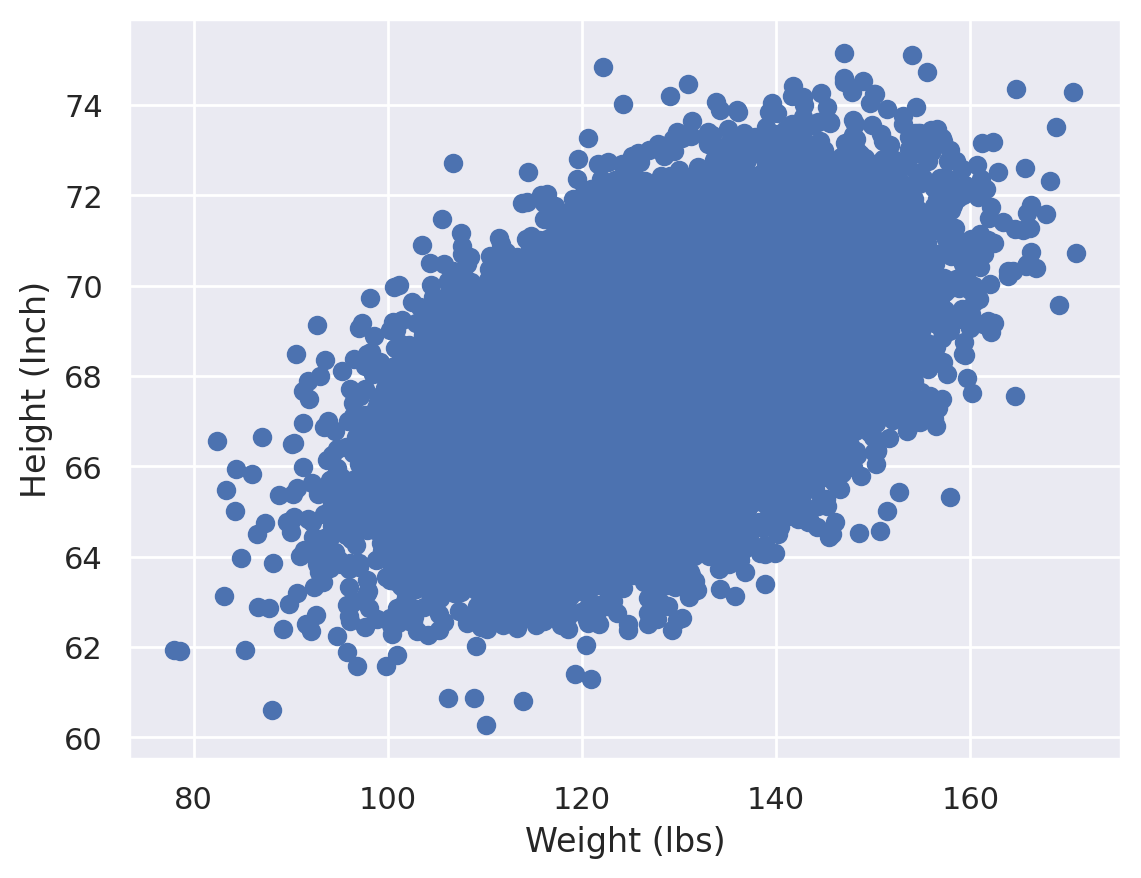

In [4]:
plt.scatter(data_demo["Weight"], data_demo["Height"])
plt.xlabel("Weight (lbs)")
plt.ylabel("Height (Inch)");

In [5]:
X, y = data_demo["Weight"].values, data_demo["Height"].values

70% данных мы оставляем в качестве обучающего набора, а 30% - в качестве тестового. Также мы масштабируем данные.

In [6]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.3, random_state=17
)

In [7]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.reshape([X_train.shape[0], 1]))
X_valid_scaled = scaler.transform(X_valid.reshape([X_valid.shape[0], 1]))

Обучите созданный `SGDRegressor` на данных `(X_train_scaled, y_train)`. Значения параметров пока оставим по умолчанию.

In [8]:
%%time

sgd_reg = SGDRegressor()
sgd_reg.fit(X_train_scaled, y_train)

  0%|          | 0/10 [00:00<?, ?it/s]

CPU times: user 2min 21s, sys: 5min 17s, total: 7min 39s
Wall time: 38.4 s


SGDRegressor()

Построить график процесса обучения - зависимость средней квадратичной ошибки от номера итерации i-й SGD.

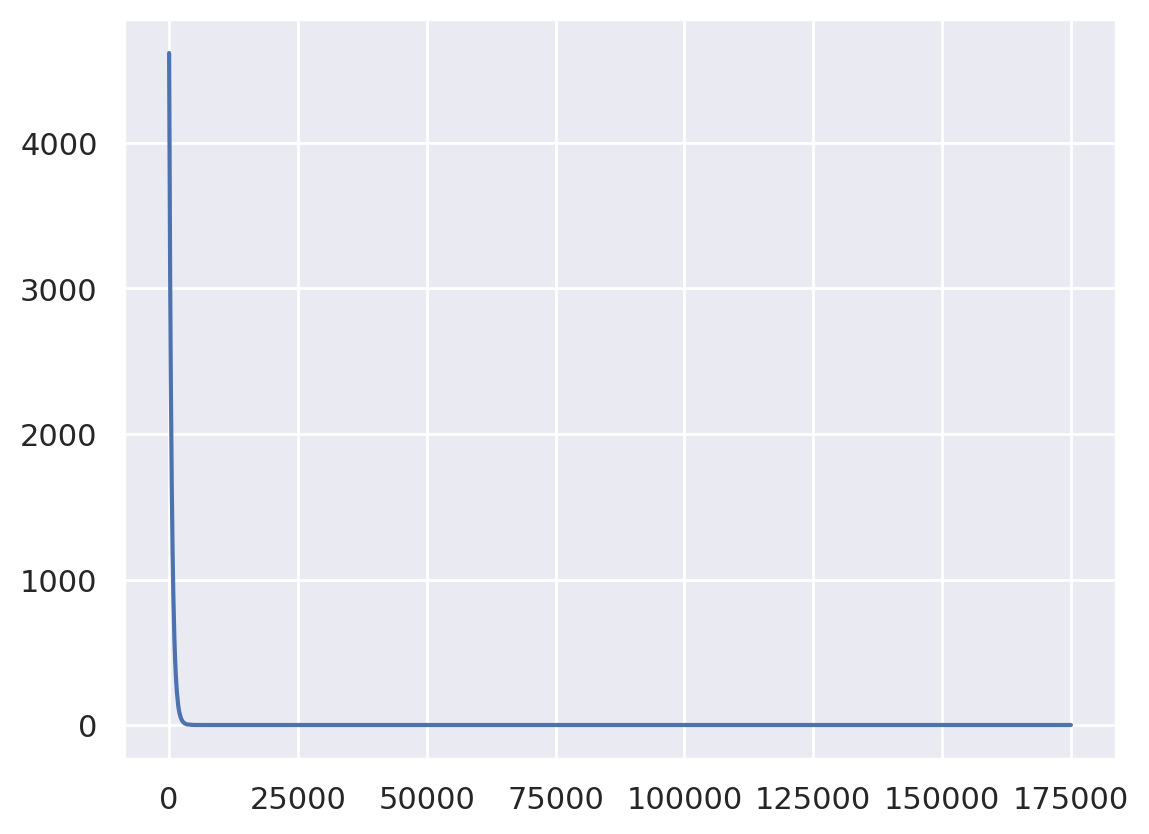

In [9]:
plt.plot(range(len(sgd_reg.mse_)), sgd_reg.mse_);

Выведите минимальное значение средней квадратичной ошибки и вектор наилучших весов.

In [10]:
print(f"min mse: {np.min(sgd_reg.mse_)}\nbest weights: {sgd_reg.w_}")

min mse: 2.7151352406643623
best weights: [67.9898497   0.94447605]


Построить график изменения весов модели ($w_0$ и $w_1$) в процессе обучения.

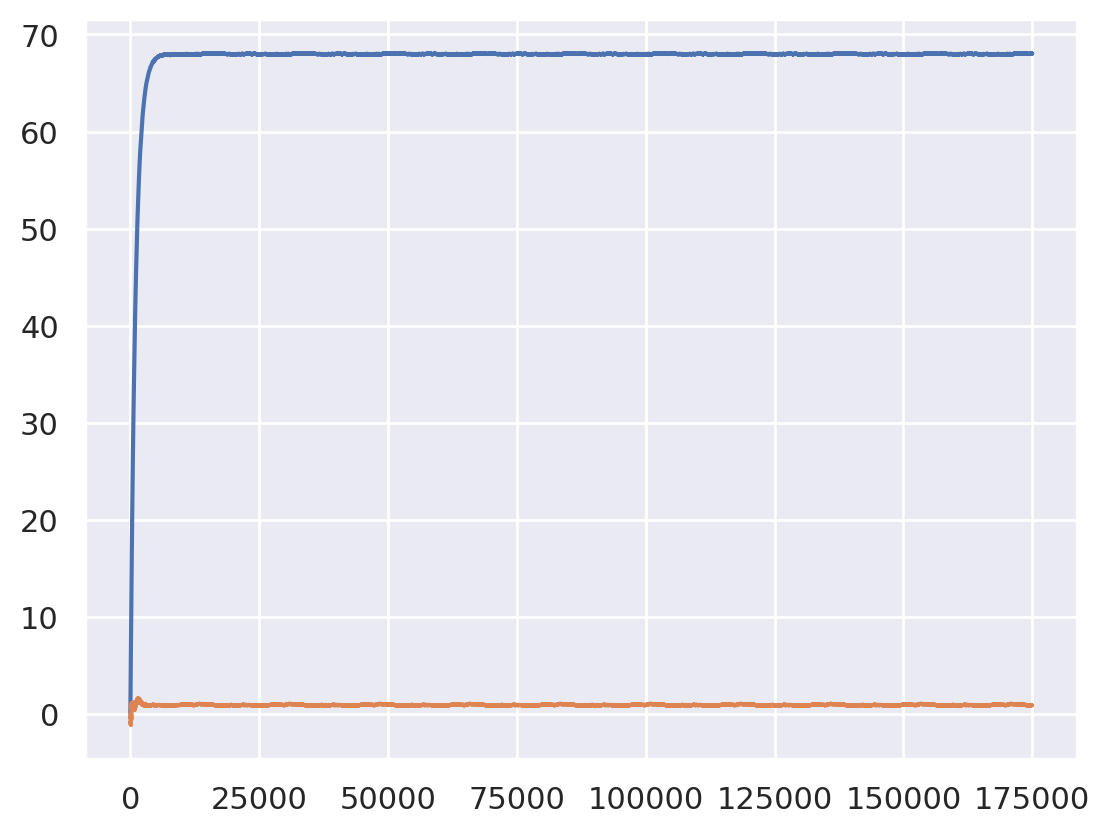

In [11]:
plt.plot(range(len(sgd_reg.weights_)), [w[0] for w in sgd_reg.weights_])
plt.plot(range(len(sgd_reg.weights_)), [w[1] for w in sgd_reg.weights_]);

Сделать прогноз для отложенного тестового набора `(X_valid_scaled, y_valid)` и проверить соответствующее значение MSE.

In [12]:
y_pred = sgd_reg.predict(X_valid_scaled)

print(f"hold-out mse: {mean_squared_error(y_valid, y_pred)}")

hold-out mse: 2.6708681207033784


Теперь проделайте то же самое для класса `LinearRegression` из `sklearn.linear_model`. Оценим MSE для того же hold-out набора.

In [13]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
print(lr.coef_, lr.intercept_)

y_pred = lr.predict(X_valid_scaled)
print(f"lr hold-out mse: {mean_squared_error(y_valid, y_pred)}")

[0.94537278] 67.98930834742858
lr hold-out mse: 2.670830767667635


**Вопрос 1. В каком десятичном значении мы видим разницу между MSE для линейного регрессора и `SGDRegressor`?**
 - 2
 - 3
 - 4
 - 5
 ```
 sgd mse: 2.6708681207033784
  lr mse: 2.670830767667635
 ```
 **Ответ:** 5

## 2. Логистическая Регрессия и Стохастический Градиентный Спуск (SGD)

Теперь разберемся, как этот же стохастический подход может помочь в обучении логистической регрессии.

Рассмотрим задачу классификации, где $X$ - обучающий набор данных размером $\ell \times (d+1)$ (первый столбец - вектор единиц), а $y$ - целевой вектор, $y_i \in \{-1, 1\}$. В [топике 4, часть 2](https://mlcourse.ai/book/topic04/topic4_linear_models_part2_logit_likelihood_learning.html#logistic-regression-as-a-linear-classifier) этого курса мы описали, как логистическая регрессия с $L_2$-регуляризацией приводит к следующей задаче минимизации:

$$\large C\sum_{i=1}^\ell \log{(1 + e^{-y_iw^Tx_i})} + \frac{1}{2}\sum_{j=1}^d w_j^2 \rightarrow min_w$$

**Вопрос 2. Какая формула будет использоваться для обновления весов логистической регрессии при обучении методом стохастического градиентного спуска (SGD)?**
 - $w_j^{(t+1)} = w_j^{(t)} + \eta (Cy_i x_{ij} \sigma(y_iw^Tx_i) +  \delta_{j\neq0} w_j)$
 - $w_j^{(t+1)} = w_j^{(t)} - \eta (Cy_i x_{ij} \sigma(-y_iw^Tx_i) +  \delta_{j\neq0}w_j)$
 - $w_j^{(t+1)} = w_j^{(t)} - \eta (Cy_i x_{ij} \sigma(y_iw^Tx_i) -  \delta_{j\neq0}w_j )$
 - $w_j^{(t+1)} = w_j^{(t)} + \eta (Cy_i x_{ij} \sigma(-y_iw^Tx_i) -  \delta_{j\neq0}w_j)$
 
Где:
- $i \in {0,\ldots, \ell-1}, j \in {0,\ldots, d}$
- $C$ – коэффициент регуляризации,
- $x_{ij} $ – элемент матрицы $X$ в строке $i$ и столбце $j$ (индексация начинается с 0),
- $x_i$ – $i$-я строка матрицы $X$ (индексация с 0),
- $w_j^{(t)}$ – значение $j$-го элемента вектора весов $w$ на шаге $t$ стохастического градиентного спуска,
- $\eta$ – малая постоянная величина, шаг градиентного спуска,
- $\delta_{j\neq0}$ – символ Кронекера, т.е. 1, если $j\neq0$ и $0$ в противном случае.

**Решение:**

$$\large J(w) = C\sum_{i=1}^\ell \log{(1 + e^{-y_iw^Tx_i})} + \frac{1}{2}\sum_{j=1}^d w_j^2$$

Во-первых, дифференцировать $\large f(z) = \log{(1 + e^{-z})}$:

$$\large \frac{df}{dz} = \frac{1}{1 + e^{-z}}\frac{d(1 + e^{-z})}{dz} = -\frac{1}{1 + e^{-z}}e^{-z} = -\frac{1}{e^z+1} = -\sigma(-z)$$

Далее,

$$\large \frac{\partial{J}}{\partial{w_0}} = -C\sum_{i=1}^\ell \sigma(-y_iw^Tx_i) \frac{d(y_iw^Tx_i)}{dw_0} = -C\sum_{i=1}^\ell \sigma(-y_iw^Tx_i)~y_i$$

Для $\large j \neq 0$:

$$\large \frac{\partial{J}}{\partial{w_j}} = -C\sum_{i=1}^\ell \sigma(-y_iw^Tx_i) \frac{d(y_iw^Tx_i)}{dw_j} + \frac{d(\frac{1}{2}\sum_{j=1}^d w_j^2)}{dw_j} = -C\sum_{i=1}^\ell \sigma(-y_iw^Tx_i)~y_ix_{ij} + w_j$$

Обновление весов для градиентного спуска (на этот раз не стохастическое):

$$\large w_j^{(t+1)} = w_j^{(t)} -\eta \frac{\partial{J}}{\partial{w_j}}$$

или

$$\large w_0^{(t+1)} = w_0^{(t)} +\eta C\sum_{i=1}^\ell \sigma(-y_iw^Tx_i)~y_i$$
$$\large w_j^{(t+1)} = w_j^{(t)} +\eta (C\sum_{i=1}^\ell \sigma(-y_iw^Tx_i)~y_ix_{ij} - w_j), j\in 1 \ldots d$$

При стохастическом подходе мы убираем суммирование:

$$\large w_j^{(t+1)} = w_j^{(t)} + \eta (Cy_i x_{ij} \sigma(-y_iw^Tx_i) - \delta_{j\neq0}w_j)$$

**Ответ:**

4. $\large w_j^{(t+1)} = w_j^{(t)} + \eta (Cy_i x_{ij} \sigma(-y_iw^Tx_i) - \delta_{j\neq0}w_j)$

Реализуем класс `SGDClassifier`. Спецификации класса:
- мы наследуем наш класс от `sklearn.base.BaseEstimator`;
- конструктор имеет следующие параметры: `eta` - шаг градиентного спуска (по умолчанию $10^{-3}$), `n_iter` - количество итераций (по умолчанию 10) и `C` - коэффициент регуляризации;
- Дополнительно создадим списки `loss_` и `weights_` для отслеживания значений логистических потерь и весового вектора в течение итераций градиентного спуска;
- класс имеет методы `fit`, `predict` и `predict_proba`;
- Метод `fit` имеет параметры `X`(матрица) и `y`(вектор) (объекты `numpy.array`, мы предполагаем, что у нас бинарная классификация, и значения в векторе `y` могут быть только -1 или 1). Мы добавляем в `X` слева столбец единиц, инициализируем вектор `w` значением **zeros** и итеративно (`n_iter` раз) обновляем веса с помощью полученного ранее выражения, также записывая значения log_loss и веса `w` в соответствующие списки;
- В конце `fit` должен создать `w_` и хранить весовой вектор с наименьшим значением потерь;
- Метод `fit` должен возвращать объект типа `SGDClassifier`, т.е. `self`;
- Метод `predict_proba` получает матрицу `X`, добавляет слева столбец единиц и возвращает матрицу с предсказаниями (такие же матрицы вы получите из методов `predict_proba` в `sklearn`), используя вектор `w_`, созданный методом `fit`;
- Метод `predict` вызывает метод `predict_proba` и возвращает вектор ответов: -1, если предсказанная вероятность 1 меньше 0.5, и 1 в противном случае;
- И **важно**: чтобы избежать проблем с вычислением больших и малых значений с экспонентой (переполнение и недополнение), используйте следующую функцию `sigma`.

In [14]:
def sigma(x):
    return np.where(x >= 0, 1 / (1 + np.exp(-x)), np.exp(x) / (1 + np.exp(x)))

In [15]:
class SGDClassifier(BaseEstimator):
    def __init__(self, C=1, eta=1e-3, n_iter=10):
        self.C = C
        self.eta = eta
        self.n_iter = n_iter
        
        self.loss_ = []
        self.weights_ = []


    def fit(self, X, y):
        X = np.hstack([np.ones([X.shape[0], 1]), X])
        best_loss = np.inf
        w = np.zeros(X.shape[1])
        
        for it in tqdm(range(self.n_iter)):
            for i in range(X.shape[0]):
                new_w = w.copy()

                new_w[0] += self.eta * self.C * y[i] * sigma(-y[i] * w.dot(X[i, :]))
                
                for j in range(1, X.shape[1]):
                    new_w[j] += self.eta * (
                        self.C * y[i] * X[i, j] * sigma(-y[i] * w.dot(X[i, :])) - w[j]
                    )

                w = new_w.copy()

                self.loss_.append(log_loss(y, sigma(X.dot(w))))
                self.weights_.append(w)

        self.w_ = self.weights_[np.argmin(self.loss_)]
        return self
    
    def predict_proba(self, X):
        X = np.hstack([np.ones([X.shape[0], 1]), X])
        p_vec = sigma(X.dot(self.w_)).reshape([X.shape[0], 1])
        return np.hstack([1 - p_vec, p_vec])
    
    def predict(self, X):
        pred_probs = self.predict_proba(X)[:, 1]
        signs = np.sign(pred_probs - 0.5)
        signs[np.where(signs == 0)] = 1
        return signs

Протестируем `SGDClassifier` на наборе данных UCI по раку молочной железы.

In [16]:
from sklearn.datasets import load_breast_cancer

In [17]:
cancer = load_breast_cancer()
# change labels in y from 0 to -1
X, y = cancer.data, [-1 if i == 0 else 1 for i in cancer.target]

Разделим набор данных на 70% для обучения и 30% - в качестве резервного набора. Также проведем масштабирование данных.

In [18]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.3, random_state=17
)

In [19]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)

Обучить `SGDClassifier` на масштабированном обучающем наборе со следующими параметрами: `C`=1, `eta`=$10^{-3}$ и `n_iter`=3.

In [20]:
sgd_clf = SGDClassifier(C=1., eta=1e-3, n_iter=3)

In [21]:
sgd_clf.fit(X_train_scaled, y_train)

  0%|          | 0/3 [00:00<?, ?it/s]

SGDClassifier(C=1.0, n_iter=3)

Построить график изменения `log_loss` в процессе обучения.

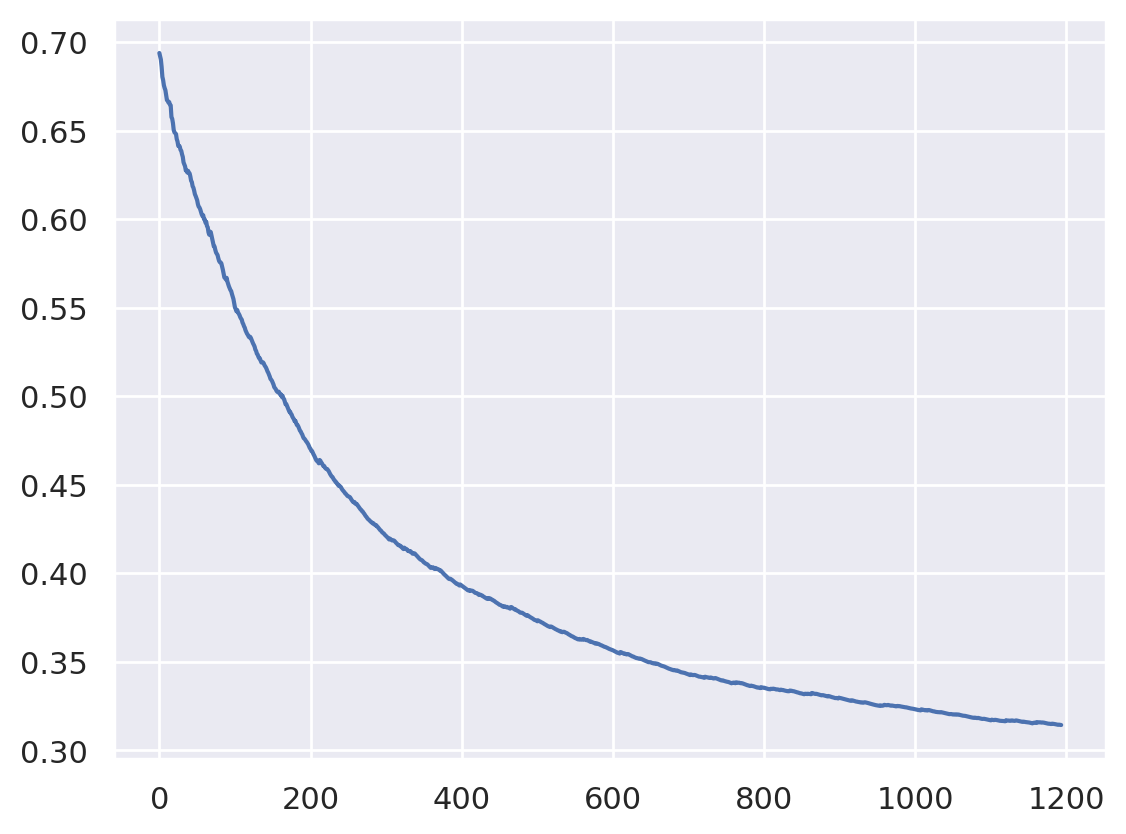

In [22]:
plt.plot(range(len(sgd_clf.loss_)), sgd_clf.loss_);

Теперь обучим `SGDClassifier` с `C`=1000, увеличив количество итераций на обучающем множестве до 10.

  0%|          | 0/10 [00:00<?, ?it/s]

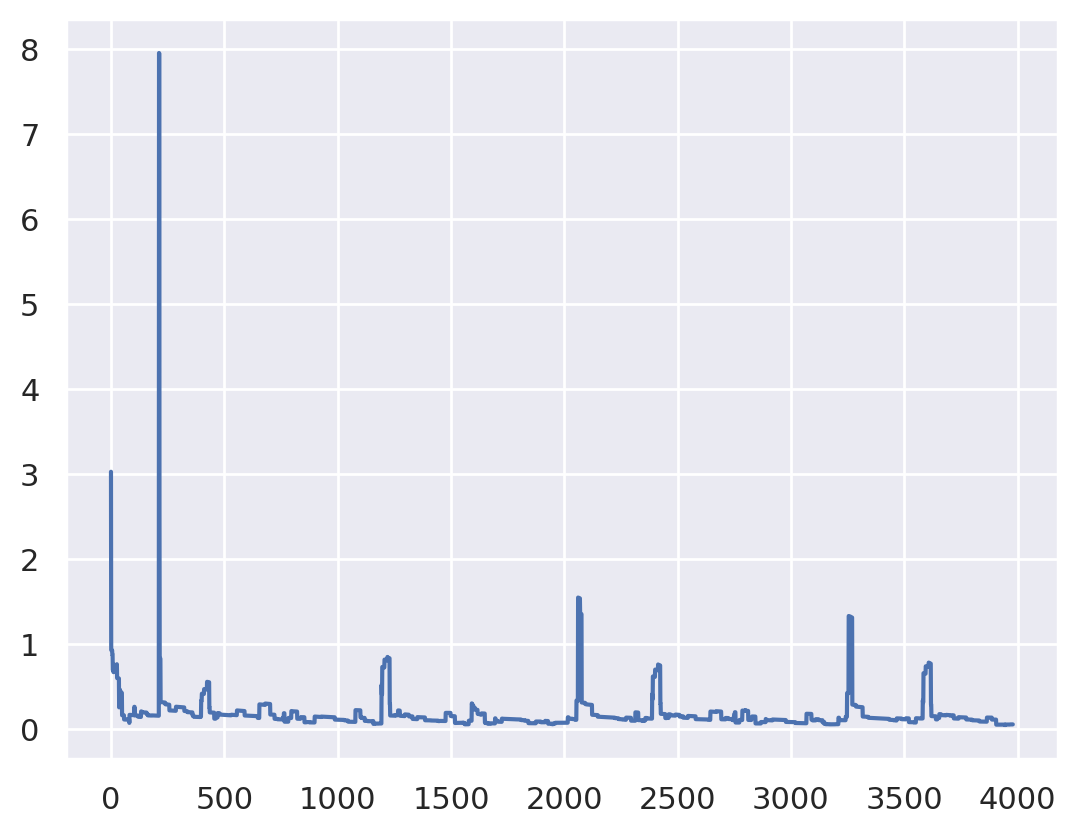

In [23]:
sgd_clf = SGDClassifier(C=1000, n_iter=10)
sgd_clf.fit(X_train_scaled, y_train)
plt.plot(range(len(sgd_clf.loss_)), sgd_clf.loss_);

Теперь проверим вектор весов модели с минимальными потерями на обучающем множестве.

**Вопрос 3. Какой признак оказывает наибольшее влияние на вероятность доброкачественной опухоли, согласно модели `SGDClassifier`? (внимательно проверьте длину весового вектора, полученного после обучения, и сравните с количеством признаков в нашей задаче)**.

 - worst compactness
 - worst smoothness
 - worst concavity
 - concave points error
 - concavity error
 - compactness error
 - worst fractal dimension
 
 **Ответ:** worst concavity

In [24]:
pd.DataFrame(
    {
        "coef": sgd_clf.w_,
        "feat": ["intercept"] + list(cancer.feature_names)
    }
).sort_values(by="coef").head(1)

,coef,feat
27,-5.107343,worst concavity


Вычислить log_loss и ROC AUC для hold-out валидационного набора, проделать все то же самое с `sklearn.linear_model.LogisticRegression` (оставить параметры по умолчанию для этого объекта, только задать random_state=17) и сравнить результаты.

In [25]:
y_pred = sgd_clf.predict_proba(X_valid_scaled)[:, 1]

In [26]:
log_loss(y_valid, y_pred)

0.4344110793957967

In [27]:
roc_auc_score(y_valid, y_pred)

0.9763040238450075

In [28]:
from sklearn.linear_model import LogisticRegression

logit = LogisticRegression(random_state=17).fit(X_train_scaled, y_train)

print(cancer.feature_names[np.argmin(logit.coef_.flatten())])

y_pred = logit.predict_proba(X_valid_scaled)[:, 1]

print(log_loss(y_valid, y_pred))
print(roc_auc_score(y_valid, y_pred))

radius error
0.10855223162448314
0.9885245901639343


## 3. Логистическая Регрессия и SGDClassifier и задача классификации кинорецензий

Рассмотрим логистическую регрессию и ее SGD-вариант для классификации рецензий с IMDB.

Мы импортируем данные и обучим `CountVectorizer` на имеющихся данных.

In [29]:
from sklearn.datasets import load_files
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import SGDClassifier

In [30]:
import os
import gdown

if not os.path.exists("../data/movie_reviews_train.csv.zip"):
    gdown.download(id="12OPgwkx5Q63iqxXGR3MqZQpiMev_aB7g", output="../data/movie_reviews_train.csv.zip")

In [31]:
reviews = pd.read_csv("../data/movie_reviews_train.csv.zip")

In [32]:
reviews.head()

,label,text
0,1,"To an entire generation of filmgoers, it just ..."
1,1,Pixar classic is one of the best kids' movies ...
2,1,Apesar de representar um imenso avanço tecnoló...
3,1,"When Woody perks up in the opening scene, it's..."
4,1,Introduced not one but two indelible character...


Выполнить разбиение на тренировочные и валидационные части.

In [33]:
reviews_train, reviews_valid, y_train, y_valid = train_test_split(
    reviews["text"], reviews["label"], test_size=0.3, random_state=17
)

Мы собираемся обучить `CountVectorizer` на имеющихся у нас данных при подсчете биграмм. Таким образом, мы приходим к разреженному представлению данных, где для каждого уникального слова и пары последовательных слов есть свой признак. Таким образом, мы получаем более 1,5 млрд. признаков.

In [34]:
%%time
cv = CountVectorizer(ngram_range=(1, 2))
X_train = cv.fit_transform(reviews_train)
X_valid = cv.transform(reviews_valid)

CPU times: user 17.9 s, sys: 353 ms, total: 18.3 s
Wall time: 18.3 s


In [35]:
X_train.shape, X_valid.shape

((106827, 2238247), (45783, 2238247))

Обучить логистическую регрессию с данными `(X_train, y_train)` и параметрами по умолчанию (за исключением `random_state`= 17 для получения воспроизводимого результата) и рассчитать ROC AUC на валидационном множестве. Измерьте время обучения модели. Масштабировать данные не нужно, поскольку наши признаки являются счетчиками и уже распределены примерно в одинаковых диапазонах.

In [36]:
%%time

logit = LogisticRegression().fit(X_train, y_train)

roc_auc_score(y_valid, logit.predict_proba(X_valid)[:, 1])

CPU times: user 2min 22s, sys: 3min 54s, total: 6min 16s
Wall time: 40.3 s


/home/m-melgizin/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.9066679675341434

--------
Теперь перейдем к онлайн алгоритму. Мы реализовали наш `SGDClassifier` и поняли, как он работает, но требуются дополнительные усилия, чтобы сделать его эффективным, например, для поддержки разреженных признаков. Перейдем к `sklearn`-реализации SGD-алгоритма. Ознакомьтесь с документацией по [SGDClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html) и отметьте, в каких аспектах `SGDClassifier` из `Sklearn` более совершенен, чем наш собственный SGD.

**Вопрос 4. В каких аспектах реализация `sklearn` является более совершенной, чем реализованный нами `SGDClassifier`? Выберите все правильные варианты.**

 - Шаг градиентного спуска можно варьировать
 - Реализована линейная SVM
 - Реализована ранняя остановка для предотвращения перебора
 - Может работать на нескольких процессорах
 - Поддерживается LASSO
 - Поддерживается онлайн-обучение деревьев решений
 - Поддерживается мини-пакетное обучение (т.е. обновление весов на нескольких обучающих примерах за один раз)
 
**Ответ:** 1, 2, 4, 5, 7

Выполните 100 итераций SGD-логистической регрессии (снова `random_state`=17) с теми же данными. Измерьте время обучения и отметьте, насколько быстрее работает SGD-версия.

In [37]:
sgd_logit = SGDClassifier(loss="log", random_state=17, max_iter=100)

In [38]:
%%time

sgd_logit.fit(X_train, y_train)
roc_auc_score(y_valid, sgd_logit.predict_proba(X_valid)[:, 1])

/home/m-melgizin/.local/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


CPU times: user 2.61 s, sys: 973 ms, total: 3.58 s
Wall time: 2.26 s


0.8987843818653956

**Вопрос 5. В каком десятичном значении мы видим разницу между валидационными ROC AUC-ми для логистической регрессии и классификатора `sklearn` SGD с логистической функцией потерь?**
 - 2
 - 3
 - 4
 - 5
 
**Ответ:** 3